# Modelisation de la consommation totale d'energie

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.preprocessing as sk_prepro
from sklearn import metrics

In [2]:
df = pd.read_csv('data_full.csv')

In [3]:
data_num = df
target_tag = 'SiteEnergyUse(kBtu)'
target = data_num[target_tag]
data_num = data_num.drop(labels = [target_tag, 'TotalGHGEmissions', 'ENERGYSTARScore','SiteEUI(kBtu/sf)'], axis = 1)

In [4]:
data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630 entries, 0 to 1629
Columns: 541 entries, 0 to ThirdLargestPropertyUseTypeGFA
dtypes: float64(541)
memory usage: 6.7 MB


## Modèle linéaire

In [5]:
from sklearn.linear_model import Ridge
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor

In [6]:
#first let's test this on knregressoe
xtrain, xtest, ytrain, ytest = train_test_split(data_num, target, test_size = 0.2)

#let's standard scale

sscaler = sk_prepro.StandardScaler()
sscaler_fit = sscaler.fit(xtrain)
xtrain = sscaler_fit.transform(xtrain)
xtest = sscaler_fit.transform(xtest)
#log scale the target
ytrain = np.log(ytrain)
ytest = np.log(ytest)


In [7]:
from sklearn import linear_model
line_reg = linear_model.LinearRegression()

In [8]:
def true_pred_plot(y_train,pred_train, y_test, pred_test):
    fig, ax = plt.subplots(2, figsize = (10,10))
    
    line_reg_train = line_reg.fit(np.array(pred_train).reshape(-1,1),y_train)
    r2_train = line_reg_train.score(np.array(pred_train).reshape(-1,1),y_train)
    rmse_train = (np.sqrt(metrics.mean_squared_error(y_train, pred_train))/np.mean(ytrain))
    a = float(line_reg_train.coef_)
    b= line_reg_train.intercept_
    ax[0].scatter( y_train, pred_train)
    ax[0].plot([a*np.abs(b)+b, a*y_train.max()+b],[np.abs(b), ytrain.max()], linestyle = 'dashed')
    ax[0].text(0.7,0.4,'R2 : {:.3f} NRMSE : {: .2f}'.format(r2_train,rmse_train), transform = ax[0].transAxes)
    ax[0].set_xlabel('True values')
    ax[0].set_ylabel('Predicted values')
    ax[0].set_xlim(y_train.min(),y_train.max())
    ax[0].set_ylim(pred_train.min(),pred_train.max())
    ax[0].set_title('On train values')

    line_reg_test  = line_reg.fit(np.array(pred_test).reshape(-1,1),y_test)
    r2_test =  line_reg_test.score(np.array(pred_test).reshape(-1,1),y_test)
    rmse_test = (np.sqrt(metrics.mean_squared_error(y_test, pred_test))/np.mean(ytest))
    a = float(line_reg_test.coef_)
    b=  line_reg_test.intercept_
    ax[1].scatter( y_test, pred_test)
    ax[1].plot([a*np.abs(b)+b, a*y_test.max()+b],[np.abs(b), y_test.max()], linestyle = 'dashed')
    ax[1].text(0.7,0.4,'R2 : {:.3f} NRMSE : {: .2f}'.format(r2_test, rmse_test), transform = ax[1].transAxes)
    ax[1].set_xlabel('True values')
    ax[1].set_ylabel('Predicted values')
    ax[1].set_xlim(y_test.min(),y_test.max())
    ax[1].set_ylim(pred_test.min(),pred_test.max())
    ax[1].set_title('On test values')
    
    plt.show()
    plt.clf()

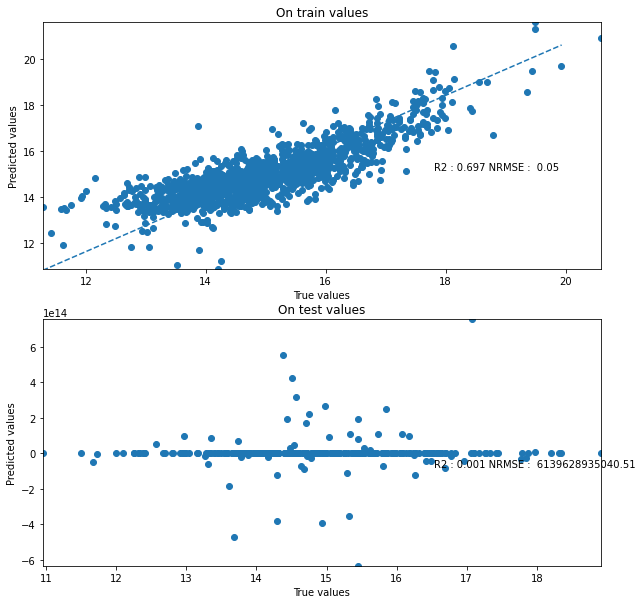

<Figure size 432x288 with 0 Axes>

In [9]:
line_reg_m = linear_model.LinearRegression()

line_reg_m.fit(xtrain,ytrain)


true_pred_plot(ytrain, line_reg_m.predict(xtrain), ytest, line_reg_m.predict(xtest))

In [10]:
#let's grid search for the k

k_grid = {'n_neighbors' : list(range(2,16))}
score = 'r2'

reg = GridSearchCV(KNeighborsRegressor(), k_grid, cv =3, scoring = score, verbose = 1)

reg.fit(xtrain, ytrain)

print('Best params on training set : {}'.format(reg.best_params_))

print('GridCV results : ')
for mean, std, k in zip(reg.cv_results_['mean_test_score'],
                       reg.cv_results_['std_test_score'],
                       reg.cv_results_['params']):
    print('{} = {:.3f} (+/- {:.3f}) for {}'.format(score,mean,std*2,k))

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best params on training set : {'n_neighbors': 7}
GridCV results : 
r2 = 0.375 (+/- 0.046) for {'n_neighbors': 2}
r2 = 0.404 (+/- 0.022) for {'n_neighbors': 3}
r2 = 0.413 (+/- 0.022) for {'n_neighbors': 4}
r2 = 0.426 (+/- 0.048) for {'n_neighbors': 5}
r2 = 0.426 (+/- 0.047) for {'n_neighbors': 6}
r2 = 0.433 (+/- 0.063) for {'n_neighbors': 7}
r2 = 0.432 (+/- 0.080) for {'n_neighbors': 8}
r2 = 0.430 (+/- 0.081) for {'n_neighbors': 9}
r2 = 0.426 (+/- 0.076) for {'n_neighbors': 10}
r2 = 0.423 (+/- 0.078) for {'n_neighbors': 11}
r2 = 0.425 (+/- 0.071) for {'n_neighbors': 12}
r2 = 0.424 (+/- 0.072) for {'n_neighbors': 13}
r2 = 0.421 (+/- 0.061) for {'n_neighbors': 14}
r2 = 0.416 (+/- 0.061) for {'n_neighbors': 15}


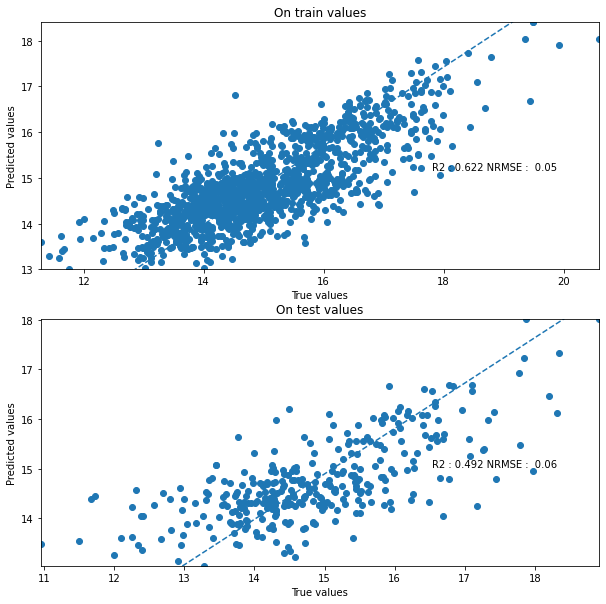

<Figure size 432x288 with 0 Axes>

In [11]:
model = KNeighborsRegressor(n_neighbors=7).fit(xtrain, ytrain)

true_pred_plot(ytrain, model.predict(xtrain), ytest, model.predict(xtest))

In [12]:
#let's try with a svr
C_range = [1.0, 5.0, 10.0, 100.0]
kernels = ['linear', 'rbf', 'sigmoid', 'poly']
degrees = [2,3,4]
gamma_range  = np.logspace(-2, 1, 10)
#gamma_range = np.logspace(-2, 1, 10)
#'gamma' : gamma_range
param_grid = {'gamma' : gamma_range, 'kernel' : kernels, 'degree' : degrees}

score = 'neg_mean_squared_error'

svr_cv = GridSearchCV(svm.SVR(), param_grid, cv = 3, scoring = score, verbose = 1)

svr_cv.fit(xtrain, ytrain)

print('Best params on training set : {}'.format(svr_cv.best_params_))

Fitting 3 folds for each of 120 candidates, totalling 360 fits
Best params on training set : {'degree': 2, 'gamma': 0.01, 'kernel': 'rbf'}


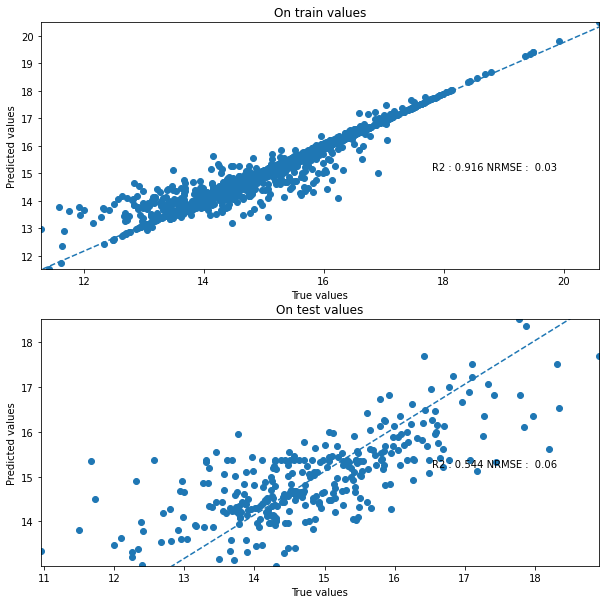

<Figure size 432x288 with 0 Axes>

In [13]:
svr = svm.SVR(kernel="rbf", C=10.0, gamma = 0.01, degree = 2)
svr = svr.fit(xtrain,ytrain)

true_pred_plot(ytrain, svr.predict(xtrain), ytest, svr.predict(xtest))

In [14]:
from sklearn import kernel_ridge
#let's try with a ridge regression


alpha_range = [1.0, 5.0, 10.0, 100.0]
kernels = ['linear', 'poly', 'sigmoid', 'rbf']
degrees = [3,4,5]
gamma_range  = np.logspace(-2, 1, 10)


param_grid = {'gamma' : gamma_range, 'kernel' : kernels, 'degree' : degrees, 'alpha' : alpha_range}

score = 'neg_mean_absolute_percentage_error'

kernel_ridge_cv = GridSearchCV(kernel_ridge.KernelRidge(), param_grid, cv = 3, scoring = score, verbose = 1)

kernel_ridge_cv.fit(xtrain, ytrain)

print('Best params on training set : {}'.format(kernel_ridge_cv.best_params_))

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_mo

Best params on training set : {'alpha': 5.0, 'degree': 3, 'gamma': 0.021544346900318832, 'kernel': 'sigmoid'}


E:\Data_Science\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:196: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


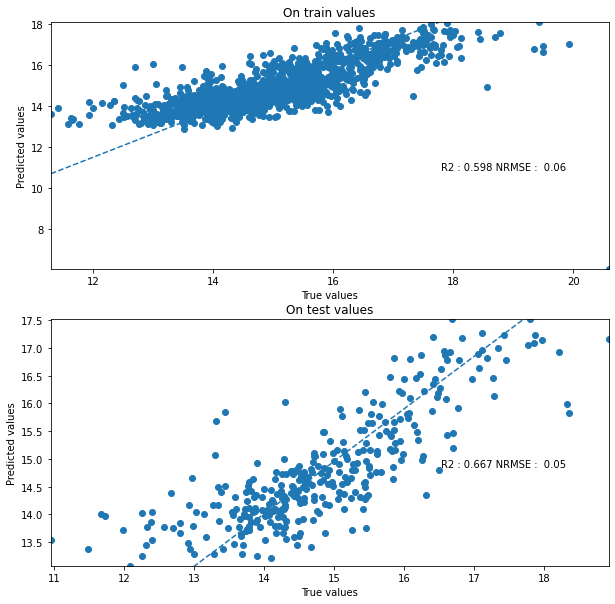

<Figure size 432x288 with 0 Axes>

In [15]:
model = kernel_ridge.KernelRidge(alpha = 5.0, kernel = 'sigmoid', degree = 3, gamma = 0.02)
model = model.fit(xtrain, ytrain)

true_pred_plot(ytrain, model.predict(xtrain), ytest, model.predict(xtest))

## Neural network

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [17]:
#test with a single perceptron
model1 = keras.Sequential()
model1.add(keras.Input(shape = xtrain.shape[1]))
model1.add(layers.Dense(1,input_dim = 2, activation = 'linear'))

model1.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model1.summary()

history1 = model1.fit(xtrain, ytrain, epochs = 50, batch_size = 1, verbose = 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 542       
                                                                 
Total params: 542
Trainable params: 542
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1304/1304 [==============================] - 2s 917us/step - loss: 107.7940 - root_mean_squared_error: 21.2301
Epoch 2/50
1304/1304 [==============================] - 1s 860us/step - loss: 86.9812 - root_mean_squared_error: 19.4227
Epoch 3/50
1304/1304 [==============================] - 1s 832us/step - loss: 78.0416 - root_mean_squared_error: 18.8141
Epoch 4/50
1304/1304 [==============================] - 1s 855us/step - loss: 69.6275 - root_mean_squared_error: 18.2243
Epoch 5/50
1304/1304 [==============================] - 1s 842us/step - loss: 62.3796 - root_mean_squ

11/11 [==============================] - 0s 891us/step


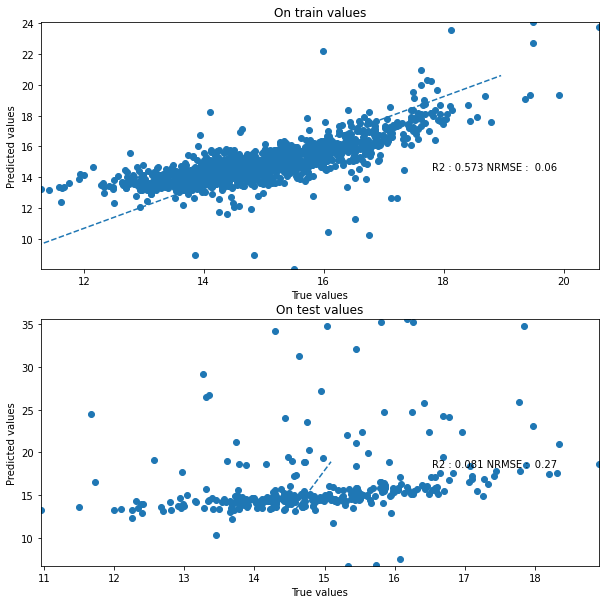

<Figure size 432x288 with 0 Axes>

In [18]:
true_pred_plot(ytrain, model1.predict(xtrain), ytest, model1.predict(xtest))

In [19]:
model2 = keras.Sequential(
    [
        layers.Dense(xtrain.shape[1], activation="relu", name="layer1", input_shape=(xtrain.shape[1],), input_dim = 2),
        layers.Dense(287, activation="relu", name="layer2"),
        layers.Dense(1, activation = 'linear', name="layer3"),
    ]
)

model2.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model2.summary()

history2 = model2.fit(xtrain, ytrain, epochs = 50, batch_size = 1, verbose = 1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 541)               293222    
                                                                 
 layer2 (Dense)              (None, 287)               155554    
                                                                 
 layer3 (Dense)              (None, 1)                 288       
                                                                 
Total params: 449,064
Trainable params: 449,064
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1304/1304 [==============================] - 3s 2ms/step - loss: 17.5320 - root_mean_squared_error: 3.6781
Epoch 2/50
1304/1304 [==============================] - 3s 2ms/step - loss: 15.0605 - root_mean_squared_error: 3.1576
Epoch 3/50
1304/1304 [==============================] - 3s 2ms/step - loss: 

11/11 [==============================] - 0s 2ms/step


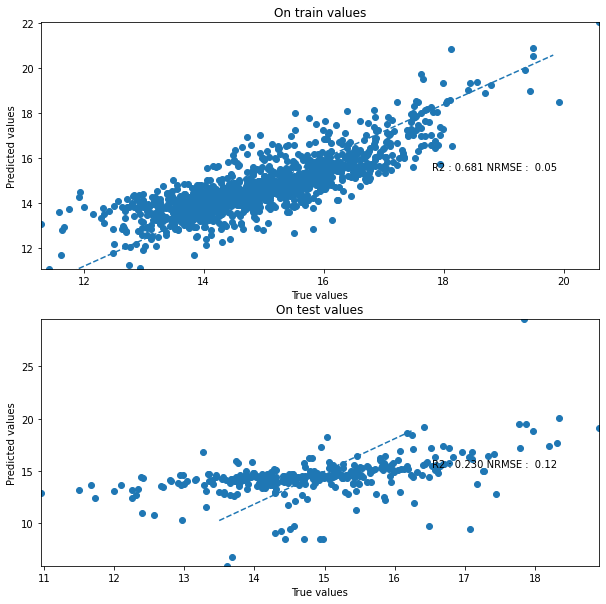

<Figure size 432x288 with 0 Axes>

In [20]:
true_pred_plot(ytrain, model2.predict(xtrain), ytest, model2.predict(xtest))

In [21]:
#now with a multi layer network

model3 = keras.Sequential(
    [
        layers.Dense(xtrain.shape[1], activation="selu", name="layer1", input_shape=(xtrain.shape[1],), input_dim = 2),
        layers.Dense(383, activation="selu", name="layer2a"),
        layers.Dense(287, activation="selu", name="layer2"),
        layers.Dense(82, activation="selu", name="layer3"),
        layers.Dense(20, activation="selu", name="layer4"),
        layers.Dense(4, activation = "selu", name = "layer5"),
        layers.Dense(1, activation = 'linear', name="layer6"),
    ]
)

model3.compile(metrics = [tf.keras.metrics.RootMeanSquaredError()], loss = 'mean_absolute_percentage_error', optimizer = 'adam')

model3.summary()

history3 = model3.fit(xtrain, ytrain, epochs = 50, batch_size = 1, verbose = 1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 541)               293222    
                                                                 
 layer2a (Dense)             (None, 383)               207586    
                                                                 
 layer2 (Dense)              (None, 287)               110208    
                                                                 
 layer3 (Dense)              (None, 82)                23616     
                                                                 
 layer4 (Dense)              (None, 20)                1660      
                                                                 
 layer5 (Dense)              (None, 4)                 84        
                                                                 
 layer6 (Dense)              (None, 1)                

11/11 [==============================] - 0s 2ms/step


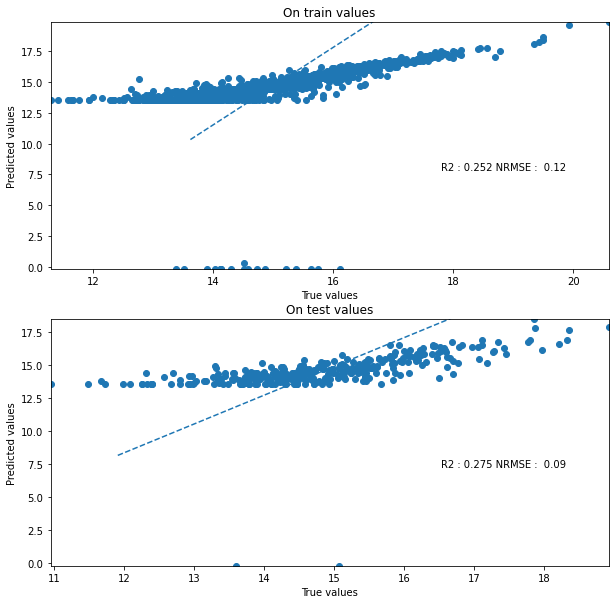

<Figure size 432x288 with 0 Axes>

In [22]:
true_pred_plot(ytrain, model3.predict(xtrain), ytest, model3.predict(xtest))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   10.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.0s finished


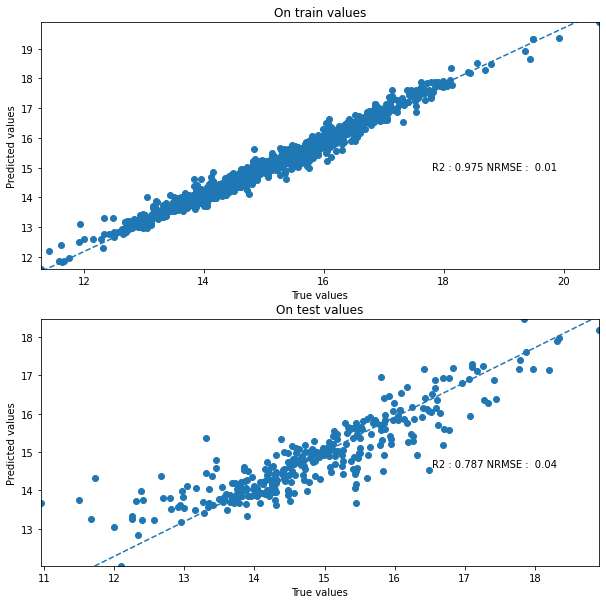

<Figure size 432x288 with 0 Axes>

In [23]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=500, verbose = 1)

model = rfr.fit(xtrain,ytrain)

true_pred_plot(ytrain, model.predict(xtrain), ytest, model.predict(xtest))

      Iter       Train Loss   Remaining Time 
         1           1.4478            9.58s
         2           1.2773            9.17s
         3           1.1350            8.76s
         4           1.0169            8.35s
         5           0.9164            8.11s
         6           0.8334            7.94s
         7           0.7633            7.70s
         8           0.7038            7.62s
         9           0.6535            7.47s
        10           0.6121            7.43s
        20           0.4010            6.86s
        30           0.3260            6.72s
        40           0.2885            6.65s
        50           0.2649            6.55s
        60           0.2485            6.56s
        70           0.2361            6.49s
        80           0.2241            6.39s
        90           0.2131            6.30s
       100           0.2057            6.20s
       200           0.1564            5.36s
       300           0.1298            4.48s
       40

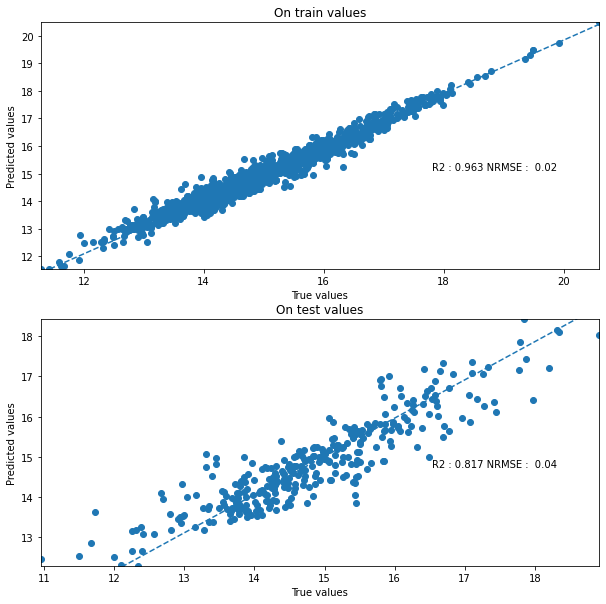

<Figure size 432x288 with 0 Axes>

In [31]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators = 800, verbose = 1)
model = gbr.fit(xtrain, ytrain)

true_pred_plot(ytrain, model.predict(xtrain), ytest, model.predict(xtest))